**сделано в Colab**

In [1]:
# подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 23.1 MB/s eta 0:00:00


In [3]:
import os
csv_path = "/content/drive/MyDrive/Colab Notebooks/raw/creditcard_1_02_00.csv"

## Попробуем Transformer, подбор гиперпараметров Optuna
- **помним про временные split, признаки и метрики те же**

## 1. Импорты


In [4]:
import os, warnings, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             average_precision_score, confusion_matrix)
from sklearn.preprocessing import RobustScaler
from IPython.display import clear_output

import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

# 2 фиксируем сиды
RANDOM_STATE = 42
def set_seed(seed=RANDOM_STATE):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## 2. Загрузка

In [5]:
df = pd.read_csv(csv_path)
print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")


Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 3.сплиты

In [6]:
time_col = 'Time_abs_hour'
def get_train_test(df, col, train_finish, train_start=0, test_finish=0, gap=0):
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test  = df[(df[col] >= test_start)  & (df[col] <= test_finish)]
    print(f"train: {df_train[col].min()}–{df_train[col].max()} | test: {df_test[col].min()}–{df_test[col].max()}")
    return df_train, df_test

train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col, train_finish)

train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col, train_finish_2)

train: 0.0–39.0 | test: 40.0–47.0
train: 0.0–31.0 | test: 32.0–39.0


## 4. Признаки и целевая переменная

In [7]:
# лишние признаки
unnecessary_cols = ['Time','Amount','Time_hour','Time_day','Amount_log', time_col]
target_col = 'Class'
drop_cols = [target_col] + unnecessary_cols

def xy(df):
    X = df.drop(drop_cols, axis=1).astype('float32').values
    y = df[target_col].values
    return X, y

X_tr,   y_tr   = xy(df_train_2)
X_val,  y_val  = xy(df_val)
X_test, y_test = xy(df_test)
X_train, y_train = xy(df_train)

# Определим n_features до objective
n_features = X_tr.shape[1]

## 5. Dataset

In [8]:
# датасет с ленивым окном
from torch.utils.data import Dataset

class LazySeqDataset(Dataset):
    """
    Хранит только 2-D X и 1-D y.
    В __getitem__ формирует окно [idx : idx+seq_len] без копирования данных.
    """
    def __init__(self, X, y, seq_len):
        super().__init__()
        self.X = X           # (N, n_features)
        self.y = y           # (N,)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.y) - self.seq_len + 1   # кол-во допустимых окон

    def __getitem__(self, idx):
        # Срез numpy не копирует память
        x_window = self.X[idx : idx + self.seq_len]   # (seq_len, n_features)
        y_target = self.y[idx + self.seq_len - 1]     # метка последнего шага
        return torch.tensor(x_window, dtype=torch.float32), \
               torch.tensor(y_target, dtype=torch.float32)

## 6. Модель Transformer

In [9]:
# Модель Transformer
#  Важно: в текущем коде нет позиционных эмбеддингов.
# Для полноценного трансформера стоит добавить nn.Parameter или sinusoidal позиции,
# иначе модель не знает, где в окне находится каждый шаг.
# Для коротких окон (seq_len ≤ 10) это может быть не критично,
# но при seq_len ≥ 20 позиции почти всегда улучшают результат.
class TransformerAnomaly(nn.Module):
    """
    Простой Transformer-энкодер для бинарной классификации на основе окна.
    Вход: (B, seq_len, n_features)
    Выход: скаляр-логит на батч (B,)

    Примечание: без кажуал mask. Для задачи детекции аномалий на окне
    использовать всю информацию окна (и «будущего» внутри окна) — допустимо.
    """
    def __init__(self, n_features, hidden_size=64, num_layers=2, dropout=0.1, n_heads=4):
        super().__init__()
        self.input_proj = nn.Linear(n_features, hidden_size)

        # Проверка кратности для multi-head attention
        if hidden_size % n_heads != 0:
            raise ValueError(f"hidden_size ({hidden_size}) должен делиться на n_heads ({n_heads})")

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=n_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True,
            activation='gelu',
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

        # Инициализация
        # Xavier-инициализация помогает стабильному старту обучения трансформеров.
        # Смещения обычно инициализируются нулями.
        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.zeros_(self.input_proj.bias)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x = self.input_proj(x)     # (B, seq_len, hidden)
        out = self.encoder(x)      # (B, seq_len, hidden)
        last_out = out[:, -1, :]   # последний тайм-степ
        return self.fc(last_out).squeeze(-1)  # (B,)

## 7. Функция потерь и метрика

In [10]:
class PR_AUC_Metric:
    def __init__(self):
        self._name = "pr_auc"
        self._maximize = True
    def __call__(self, y_true, y_score):
        return average_precision_score(y_true, y_score)

loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([len(y_tr)/y_tr.sum()], device=device)
    )

## 8. Optuna — подбор гиперпараметров

In [11]:
def objective(trial):
    # Гиперпараметры
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    hidden_size = trial.suggest_categorical("hidden_size", [64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    n_heads = trial.suggest_categorical("n_heads", [1, 2, 4, 8])
    # seq_len = trial.suggest_int("seq_len", 1, 5)
    seq_len = trial.suggest_int("seq_len", 1, 40, log=True)

    # Совместимость для Multi-Head Attention
    if hidden_size % n_heads != 0:
        raise optuna.exceptions.TrialPruned(f"Infeasible: hidden_size {hidden_size} not divisible by n_heads {n_heads}")

    print('\ntrial started with :')
    print(f' batch_size = {batch_size}, hidden_size = {hidden_size},\n num_layers = {num_layers}, n_heads = {n_heads}, seq_len = {seq_len},\n lr = {lr}, dropout = {dropout}')



    model = TransformerAnomaly(
            n_features=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            n_heads=n_heads
        ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)


    # 1. DataLoader, который делает окна «на лету»
    tr_ds = LazySeqDataset(X_tr, y_tr, seq_len=seq_len)
    val_ds = LazySeqDataset(X_val, y_val, seq_len=seq_len)

    tr_loader = torch.utils.data.DataLoader(
        tr_ds, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )

    best_pr_auc = 0.0
    patience, counter = 5, 0
    epochs = 50

    for epoch in range(epochs):
        # train
        model.train()
        for X, y in tr_loader:  # X: (B, seq_len, n_features)
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # eval
        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                logits = model(X)           # (B,)
                preds.append(torch.sigmoid(logits).cpu())
                labels.append(y)
        preds = torch.cat(preds).numpy()
        labels = torch.cat(labels).numpy()

        pr_auc = average_precision_score(labels, preds)

        if pr_auc > best_pr_auc + 1e-4:
            best_pr_auc = pr_auc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            break
    print(f"\nУчились {epoch} эпох.")
    return best_pr_auc


set_seed()

n_trials=3


# Путь к базе данных Optuna
optuna_db_path = "/content/drive/MyDrive/Colab Notebooks/data/optuna_study.db"
storage_url = f"sqlite:///{optuna_db_path}"
study_name = "transformer_anomaly_study"

study = optuna.create_study(
    study_name=study_name,
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE),
    storage=storage_url,
    load_if_exists=True
)

# study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("Best trial:", study.best_trial.params)
print("Best PR-AUC:", study.best_value)

[I 2025-10-08 17:33:25,081] A new study created in RDB with name: transformer_anomaly_study


  0%|          | 0/3 [00:00<?, ?it/s]


trial started with :
 batch_size = 32, hidden_size = 64,
 num_layers = 1, n_heads = 1, seq_len = 35,
 lr = 5.6115164153345e-05, dropout = 0.017425083650459836

Учились 8 эпох.
[I 2025-10-08 17:37:26,050] Trial 0 finished with value: 0.7678301924960761 and parameters: {'lr': 5.6115164153345e-05, 'batch_size': 32, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.017425083650459836, 'n_heads': 1, 'seq_len': 35}. Best is trial 0 with value: 0.7678301924960761.

trial started with :
 batch_size = 32, hidden_size = 128,
 num_layers = 2, n_heads = 2, seq_len = 3,
 lr = 0.000462258900102083, dropout = 0.12958350559263473

Учились 14 эпох.
[I 2025-10-08 17:46:44,272] Trial 1 finished with value: 0.7753320622396453 and parameters: {'lr': 0.000462258900102083, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.12958350559263473, 'n_heads': 2, 'seq_len': 3}. Best is trial 1 with value: 0.7753320622396453.

trial started with :
 batch_size = 32, hidden_size = 128,
 num_layers = 1,

In [13]:
set_seed()

n_trials=12

study = optuna.create_study(
    study_name=study_name,
    direction="maximize",
    sampler=TPESampler(seed=RANDOM_STATE+1),
    storage=storage_url,
    load_if_exists=True
)
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("Best trial:", study.best_trial.params)
print("Best PR-AUC:", study.best_value)

[I 2025-10-08 17:55:04,854] Using an existing study with name 'transformer_anomaly_study' instead of creating a new one.


  0%|          | 0/12 [00:00<?, ?it/s]


trial started with :
 batch_size = 32, hidden_size = 128,
 num_layers = 3, n_heads = 4, seq_len = 17,
 lr = 1.6986704535055072e-05, dropout = 0.19982706392940772

Учились 19 эпох.
[I 2025-10-08 18:11:17,680] Trial 4 finished with value: 0.7525982588705536 and parameters: {'lr': 1.6986704535055072e-05, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 3, 'dropout': 0.19982706392940772, 'n_heads': 4, 'seq_len': 17}. Best is trial 2 with value: 0.7890299374693548.

trial started with :
 batch_size = 64, hidden_size = 128,
 num_layers = 1, n_heads = 4, seq_len = 33,
 lr = 3.227321652492815e-05, dropout = 0.022998809998934177

Учились 24 эпох.
[I 2025-10-08 18:17:26,464] Trial 5 finished with value: 0.7538834463279414 and parameters: {'lr': 3.227321652492815e-05, 'batch_size': 64, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.022998809998934177, 'n_heads': 4, 'seq_len': 33}. Best is trial 2 with value: 0.7890299374693548.

trial started with :
 batch_size = 32, hidden_size = 64,
 num

In [14]:
# optuna визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

## 9. Обучение финальной модели

In [16]:
def train_with_plot_and_scheduler_old(model, train_loader, val_loader, optimizer, criterion, epochs):

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    train_losses = []
    val_losses = []
    pr_aucs = []
    roc_aucs = []
    lrs = []

    for epoch in range(epochs):
        model.train()  # настраиваем на обучение
        total_loss, n = 0., 0  # задаём стартовые значения
        for X, y in train_loader:
            X, y = X.to(device), y.float().to(device)
            optimizer.zero_grad()    # обнуляем градиенты
            preds = model(X)  # prediction
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            # собираем результат в кучку
            total_loss += loss.item() * len(X)
            n += len(X)
        # среднее за эпоху
        train_loss = total_loss / n

        #
        model.eval()  # режим оценки
        # стартовая инициализация
        total_loss, n = 0., 0
        all_preds, all_labels = [], []

        for X, y in val_loader:
            X, y = X.to(device), y.float().to(device)
            with torch.no_grad():
                preds = torch.sigmoid(model(X))
            total_loss += criterion(preds, y).item() * len(X)
            n += len(X)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

        preds = torch.cat(all_preds).numpy()
        labels = torch.cat(all_labels).numpy()
        pr_auc = auc(*precision_recall_curve(labels, preds)[1::-1])
        roc_auc = roc_auc_score(labels, preds)
        val_loss = total_loss / n


        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pr_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)
        lrs.append(optimizer.param_groups[0]['lr'])

        scheduler.step()  # обновляем learning rate

        # Обновление графика
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # Потери
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss по эпохам')
        plt.legend()
        plt.xlim(0, epochs)

        # Метрики
        plt.subplot(1, 3, 2)
        plt.plot(pr_aucs, label='PR AUC')
        plt.plot(roc_aucs, label='ROC AUC')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Тест Metrics')
        plt.legend()
        plt.xlim(0, epochs)

        # Learning Rate
        plt.subplot(1, 3, 3)
        plt.plot(lrs, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.xlim(0, epochs)

        plt.tight_layout()
        plt.show()

        print(f"Эпоха {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}, LR: {lrs[-1]:.6f}")


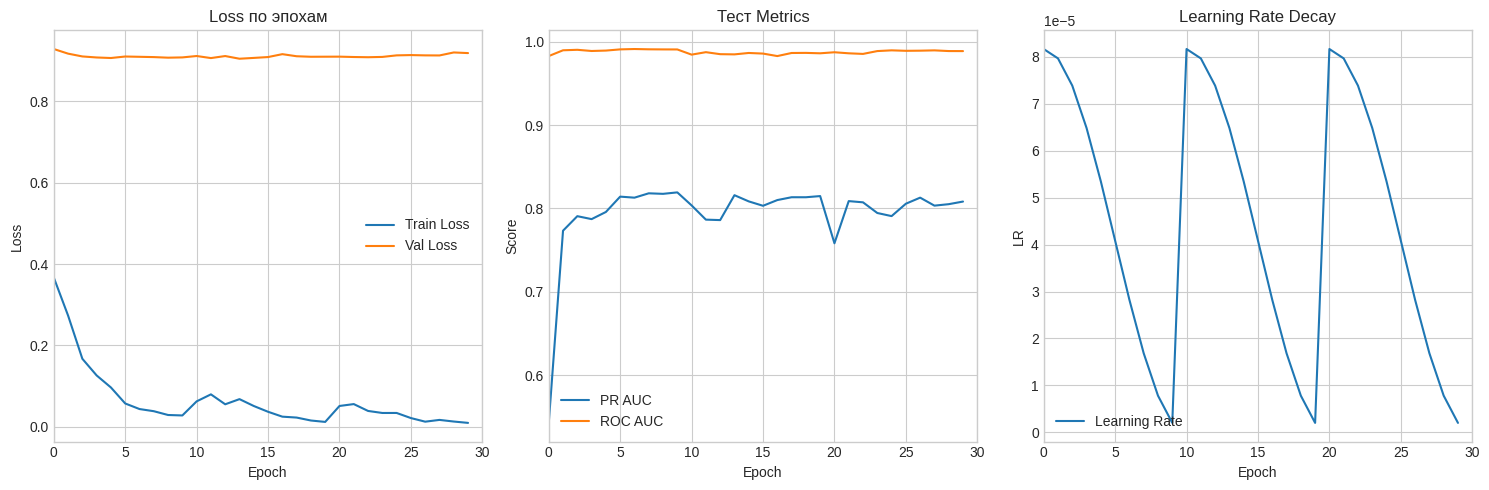

Эпоха 30/30 — Train Loss: 0.0095, Val Loss: 0.9186, PR AUC: 0.8082, ROC AUC: 0.9889, LR: 0.000002


In [17]:
set_seed()
best = study.best_trial.params
model = TransformerAnomaly(
    n_features=n_features,
    hidden_size=best["hidden_size"],
    num_layers=best["num_layers"],
    dropout=best["dropout"],
    n_heads=best["n_heads"]
).to(device)

seq_len = best['seq_len']

train_ds = LazySeqDataset(X_train, y_train, seq_len=seq_len)
test_ds = LazySeqDataset(X_test, y_test, seq_len=seq_len)

optimizer = torch.optim.AdamW(model.parameters(), lr=best["lr"])
train_with_plot_and_scheduler_old(
    model,

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=best["batch_size"], shuffle=True, drop_last=True
    ),
    val_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    ),
    optimizer=optimizer,
    criterion=loss_fn,
    epochs=30
)

## 10. Оценка на тесте

## 11. Подбор порога по валидации

In [18]:
test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    )

# 2) собираем предсказания батчами
model.eval()
all_scores, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)                # (B, seq_len, n_features)
        logits = model(xb)                # (B,)
        scores = torch.sigmoid(logits).cpu()
        all_scores.append(scores)
        all_labels.append(yb)

y_score = torch.cat(all_scores).numpy()
y_true  = torch.cat(all_labels).numpy()
y_pred = (y_score >= 0.5).astype(int)
print("Порог детекции аномалий 0,5")
print("Test PR-AUC:", average_precision_score(y_true, y_score))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:",    recall_score(y_true, y_pred))
print("F1:",        f1_score(y_true, y_pred))


# 3) подбор порога по валидации (то же самое)
val_ds = LazySeqDataset(X_val, y_val, seq_len=best["seq_len"])
val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    )
model.eval()
val_scores, val_labels = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        scores = torch.sigmoid(model(xb)).cpu()
        val_scores.append(scores)
        val_labels.append(yb)
val_score = torch.cat(val_scores).numpy()
val_labels = torch.cat(val_labels).numpy()

prec, rec, thr = precision_recall_curve(val_labels, val_score)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1_scores)]
print("\nПосле поиска порога на val")
print(f"Оптимальный порог по val: {best_thr:.7f}")

# 4) финальные метрики
y_pred = (y_score >= best_thr).astype(int)
print("Test PR-AUC:", average_precision_score(y_true, y_score))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:",    recall_score(y_true, y_pred))
print("F1:",        f1_score(y_true, y_pred))

Порог детекции аномалий 0,5
Test PR-AUC: 0.8086500564353941
Precision: 0.5943396226415094
Recall: 0.8181818181818182
F1: 0.6885245901639344

После поиска порога на val
Оптимальный порог по val: 0.9901981
Test PR-AUC: 0.8086500564353941
Precision: 0.859375
Recall: 0.7142857142857143
F1: 0.7801418439716312


## 12. Финальные метрики и визуализация

Test (порог подобран по валидации) PR-AUC=0.8082 Precision=0.859 Recall=0.714 F1=0.780


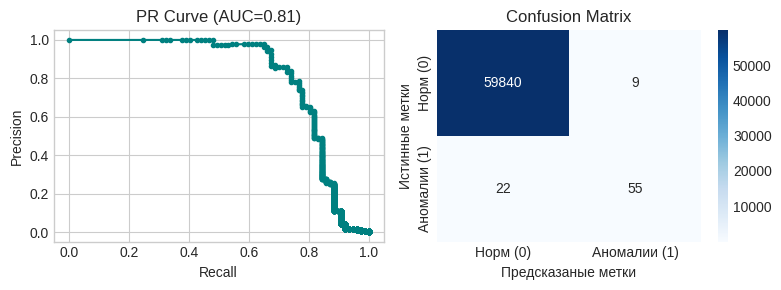

In [19]:
precision =  precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(rec, prec)

print("Test (порог подобран по валидации) "
      f"PR-AUC={pr_auc:0.4f} Precision={precision:0.3f} Recall={recall:0.3f} F1={f1:.3f}")

# визуализация
labels = ['Норм (0)', 'Аномалии (1)']
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(rec, prec, marker='.', color='teal')
axs[0].set_xlabel("Recall"); axs[0].set_ylabel("Precision")
axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_xlabel("Предсказаные метки"); axs[1].set_ylabel("Истинные метки")
axs[1].set_title("Confusion Matrix")
plt.tight_layout(); plt.show()

## 14. Выводы
**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **Простой Transformer-энкодер**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Test**     | 0.78 | 0.81   |

**Вывод**
- Модель справилась с задачей детекции аномалий лучше чем LSTM.
- использовались 17 записей, т.е. трансформер использовал небольшое временное окно для лучшего результата.
- - PR-AUC: 0.81 — допустим.
- -  Precision: 0.86, Recall: 0.71, F1: 0.78 — при пороге 0.9901981, подобранном на валидации достаточно не плох, если бы данные были разделены по картам и пользователям - результат был бы значительно выше наверное.)
- Подбор гиперпараметров через Optuna был эффективен.
- Подбор порога классификации - важен: Исходно модель с порогом 0.5 давала  Recall (0.82) ,  Precision (0.59) и F1(0.69).  Последующий подбор оптимального порога  на валидационной выборке позволил  значительно улучшить F1-меру.